https://www.adriangb.com/scikeras/stable/quickstart.html#training-a-model

https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

In [1]:
#!pip install -U -q segmentation-models

In [2]:
#!pip install scikeras

In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import sklearn
sklearn.__version__

'1.0.1'

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline

In [6]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [7]:
from tensorflow import keras
#import keras
keras.__version__

'2.5.0'

In [8]:
from scikeras.wrappers import KerasRegressor

In [9]:
%load_ext memory_profiler

In [10]:
%memit TrainingID_0 = pd.read_parquet(path='009_TraningID_0_INZYNIERIA_CECH/TraningID_0_INZYNIERIA_CECH.parquet', engine='pyarrow')

peak memory: 604.00 MiB, increment: 305.44 MiB


In [11]:
TrainingID_0.head()

,StudentID_TrainingSession,TrainingID_0_target,TrainingID_1_target,TrainingID_2_target,TrainingID_TrainingSession,"target(zdany_egzamin: 1 - zdany, 0 - nie zdany)",czy_doswiadczenie_serwisowe_pompownia,czy_doswiadczenie_serwisowe_brak,czy_doswiadczenie_serwisowe_rooftop,czy_doswiadczenie_serwisowe_klimatyzator,...,PhysicalFixationRecords_COUNT_DEVIATION_PhysicalFixationRecords_COUNT_x_TaskID_75,PhysicalFixationRecords_COUNT_DEVIATION_PhysicalFixationRecords_COUNT_x_TaskID_76,PhysicalFixationRecords_COUNT_DEVIATION_PhysicalFixationRecords_COUNT_x_TaskID_77,PhysicalFixationRecords_COUNT_DEVIATION_PhysicalFixationRecords_COUNT_x_TaskID_78,PhysicalFixationRecords_COUNT_DEVIATION_PhysicalFixationRecords_COUNT_x_TaskID_79,PhysicalFixationRecords_COUNT_DEVIATION_PhysicalFixationRecords_COUNT_x_TaskID_80,PhysicalFixationRecords_COUNT_DEVIATION_PhysicalFixationRecords_COUNT_x_TaskID_81,PhysicalFixationRecords_COUNT_DEVIATION_PhysicalFixationRecords_COUNT_x_TaskID_82,PhysicalFixationRecords_COUNT_DEVIATION_PhysicalFixationRecords_COUNT_x_TaskID_83,PhysicalFixationRecords_COUNT_DEVIATION_PhysicalFixationRecords_COUNT_x_TaskID_84
0,BADANY010507,1.0,0.0,0.0,0.0,1,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
1,BADANY010607,1.0,1.0,1.0,0.0,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.707107,0.707107,0.0,0.707107,0.0,0.000000,0.0
2,BADANY010707,1.0,1.0,1.0,0.0,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,-1.091089,0.0,-1.154701,0.0,-1.091089,0.0
3,BADANY010807,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0
4,BADANY010907,1.0,0.0,0.0,0.0,1,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0


In [49]:
TrainingID_0.shape

(92, 13628)

In [38]:
train_size = 0.8

In [39]:
columns_to_exclude = [
    'StudentID_TrainingSession',
    'TrainingID_TrainingSession',
    'target(zdany_egzamin: 1 - zdany, 0 - nie zdany)',
    'TrainingID_0_target',
    'TrainingID_1_target',
    'TrainingID_2_target'
]

In [51]:
strat_shuf_split = StratifiedShuffleSplit(train_size=train_size, random_state=7)

train_idx, test_idx = next(strat_shuf_split.split(TrainingID_0.loc[:, TrainingID_0.columns != 'target(zdany_egzamin: 1 - zdany, 0 - nie zdany)'], TrainingID_0["target(zdany_egzamin: 1 - zdany, 0 - nie zdany)"]))

X_train = TrainingID_0.loc[:, TrainingID_0.columns != 'target(zdany_egzamin: 1 - zdany, 0 - nie zdany)'].iloc[train_idx]
X_train = TrainingID_0.drop(columns_to_exclude, axis=1).iloc[train_idx]
y_train = TrainingID_0["target(zdany_egzamin: 1 - zdany, 0 - nie zdany)"].iloc[train_idx]

X_test = TrainingID_0.loc[:, TrainingID_0.columns != 'target(zdany_egzamin: 1 - zdany, 0 - nie zdany)'].iloc[test_idx]
X_test = TrainingID_0.drop(columns_to_exclude, axis=1).iloc[test_idx]
y_test = TrainingID_0["target(zdany_egzamin: 1 - zdany, 0 - nie zdany)"].iloc[test_idx]

X_tr, X_valid, y_tr, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [52]:
X_train.shape

(73, 13622)

In [53]:
X_tr.shape

(51, 13622)

In [54]:
X_valid.shape

(22, 13622)

In [55]:
X_test.shape

(19, 13622)

In [56]:
y_train.shape

(73,)

In [57]:
y_tr.shape

(51,)

In [58]:
y_valid.shape

(22,)

In [59]:
y_test.shape

(19,)

In [27]:
# Standardize Data
sc = StandardScaler()
X_tr_std = sc.fit_transform(X_tr)
X_valid_std = sc.transform(X_valid)
X_test_std = sc.transform(X_test)

### Base Autoencoder

In [35]:
encoder = keras.models.Sequential([
    keras.layers.Dense(3, input_shape=[X_tr_std.shape[1]])
])

decoder = keras.models.Sequential([
    keras.layers.Dense(X_tr_std.shape[1], input_shape=[3])
])

autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))

autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 3)                 40869     
_________________________________________________________________
sequential_7 (Sequential)    (None, 13622)             54488     
Total params: 95,357
Trainable params: 95,357
Non-trainable params: 0
_________________________________________________________________


C:\Users\KonuTech\.conda\envs\tf-gpu\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [29]:
def create_model():
    # design network
#     model = Sequential()
#     model.add(Dense(neurons_first_layer, input_dim=len(selected_features), activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(neurons_second_layer, activation=activation, kernel_initializer=init_mode, kernel_constraint=maxnorm(weight_constraint)))
#     model.add(Dropout(dropout_rate))
#     model.add(Dense(1, activation='sigmoid'))
    
#     print(model.summary())
    
    encoder = keras.models.Sequential([
        keras.layers.Dense(3, input_shape=[X_tr_std.shape[1]])
    ])

    decoder = keras.models.Sequential([
        keras.layers.Dense(X_tr_std.shape[1], input_shape=[3])
    ])

    autoencoder = keras.models.Sequential([encoder, decoder])
    #autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=0.1))

    autoencoder.summary()

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=100)
    #optimizer = keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    optimizer = keras.optimizers.SGD(lr=0.1)
    autoencoder.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])

    return autoencoder

In [30]:
create_model()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 3)                 40869     
_________________________________________________________________
sequential_4 (Sequential)    (None, 13622)             54488     
Total params: 95,357
Trainable params: 95,357
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = autoencoder.fit(
    X_tr_std,
    X_tr_std,
    epochs=1000,
    validation_data=(X_valid_std, X_valid_std),
    callbacks=[keras.callbacks.EarlyStopping(patience=100)]
)

codings = encoder.predict(X_tr_std)

Epoch 1/1000
2/2 [==============================] - 11s 261ms/step - loss: 0.9985 - val_loss: 25.1801
Epoch 2/1000
2/2 [==============================] - 0s 113ms/step - loss: 0.9984 - val_loss: 25.1801
Epoch 3/1000
2/2 [==============================] - 0s 80ms/step - loss: 0.9984 - val_loss: 25.1802
Epoch 4/1000
2/2 [==============================] - 0s 95ms/step - loss: 0.9983 - val_loss: 25.1802
Epoch 5/1000
2/2 [==============================] - 0s 95ms/step - loss: 0.9983 - val_loss: 25.1802
Epoch 6/1000
2/2 [==============================] - 0s 94ms/step - loss: 0.9983 - val_loss: 25.1802
Epoch 7/1000
2/2 [==============================] - 0s 95ms/step - loss: 0.9982 - val_loss: 25.1803
Epoch 8/1000
2/2 [==============================] - 0s 76ms/step - loss: 0.9982 - val_loss: 25.1803
Epoch 9/1000
2/2 [==============================] - 0s 80ms/step - loss: 0.9982 - val_loss: 25.1803
Epoch 10/1000
2/2 [==============================] - 0s 100ms/step - loss: 0.9981 - val_loss: 25.

2/2 [==============================] - 0s 47ms/step - loss: 0.9966 - val_loss: 25.1800
Epoch 83/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.9965 - val_loss: 25.1800
Epoch 84/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.9965 - val_loss: 25.1800
Epoch 85/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.9964 - val_loss: 25.1799
Epoch 86/1000
2/2 [==============================] - 0s 64ms/step - loss: 0.9964 - val_loss: 25.1799
Epoch 87/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.9963 - val_loss: 25.1798
Epoch 88/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.9962 - val_loss: 25.1798
Epoch 89/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.9961 - val_loss: 25.1797
Epoch 90/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.9960 - val_loss: 25.1796
Epoch 91/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.9960 - val_loss: 25.1796
Epoc

2/2 [==============================] - 0s 47ms/step - loss: 0.9404 - val_loss: 25.1268
Epoch 163/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.9383 - val_loss: 25.1247
Epoch 164/1000
2/2 [==============================] - 0s 46ms/step - loss: 0.9361 - val_loss: 25.1225
Epoch 165/1000
2/2 [==============================] - 0s 46ms/step - loss: 0.9339 - val_loss: 25.1204
Epoch 166/1000
2/2 [==============================] - 0s 50ms/step - loss: 0.9317 - val_loss: 25.1182
Epoch 167/1000
2/2 [==============================] - 0s 66ms/step - loss: 0.9294 - val_loss: 25.1160
Epoch 168/1000
2/2 [==============================] - 0s 67ms/step - loss: 0.9271 - val_loss: 25.1136
Epoch 169/1000
2/2 [==============================] - 0s 53ms/step - loss: 0.9247 - val_loss: 25.1113
Epoch 170/1000
2/2 [==============================] - 0s 66ms/step - loss: 0.9223 - val_loss: 25.1090
Epoch 171/1000
2/2 [==============================] - 0s 52ms/step - loss: 0.9201 - val_loss: 25.

2/2 [==============================] - 0s 62ms/step - loss: 0.8295 - val_loss: 25.0170
Epoch 243/1000
2/2 [==============================] - 0s 66ms/step - loss: 0.8293 - val_loss: 25.0168
Epoch 244/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.8291 - val_loss: 25.0166
Epoch 245/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.8289 - val_loss: 25.0164
Epoch 246/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.8288 - val_loss: 25.0163
Epoch 247/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.8286 - val_loss: 25.0161
Epoch 248/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.8284 - val_loss: 25.0160
Epoch 249/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.8283 - val_loss: 25.0158
Epoch 250/1000
2/2 [==============================] - 0s 64ms/step - loss: 0.8281 - val_loss: 25.0157
Epoch 251/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.8280 - val_loss: 25.

2/2 [==============================] - 0s 63ms/step - loss: 0.8244 - val_loss: 25.0125
Epoch 323/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.8244 - val_loss: 25.0125
Epoch 324/1000
2/2 [==============================] - 0s 50ms/step - loss: 0.8243 - val_loss: 25.0125
Epoch 325/1000
2/2 [==============================] - 0s 50ms/step - loss: 0.8243 - val_loss: 25.0125
Epoch 326/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.8243 - val_loss: 25.0125
Epoch 327/1000
2/2 [==============================] - 0s 50ms/step - loss: 0.8242 - val_loss: 25.0125
Epoch 328/1000
2/2 [==============================] - 0s 66ms/step - loss: 0.8242 - val_loss: 25.0124
Epoch 329/1000
2/2 [==============================] - 0s 53ms/step - loss: 0.8241 - val_loss: 25.0124
Epoch 330/1000
2/2 [==============================] - 0s 50ms/step - loss: 0.8241 - val_loss: 25.0124
Epoch 331/1000
2/2 [==============================] - 0s 66ms/step - loss: 0.8241 - val_loss: 25.

2/2 [==============================] - 0s 49ms/step - loss: 0.8198 - val_loss: 25.0112
Epoch 403/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.8197 - val_loss: 25.0112
Epoch 404/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.8197 - val_loss: 25.0111
Epoch 405/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.8196 - val_loss: 25.0111
Epoch 406/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.8195 - val_loss: 25.0110
Epoch 407/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.8194 - val_loss: 25.0110
Epoch 408/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.8193 - val_loss: 25.0110
Epoch 409/1000
2/2 [==============================] - 0s 49ms/step - loss: 0.8192 - val_loss: 25.0110
Epoch 410/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.8191 - val_loss: 25.0109
Epoch 411/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.8190 - val_loss: 25.

2/2 [==============================] - 0s 69ms/step - loss: 0.8088 - val_loss: 25.0090
Epoch 483/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.8087 - val_loss: 25.0089
Epoch 484/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.8085 - val_loss: 25.0089
Epoch 485/1000
2/2 [==============================] - 0s 73ms/step - loss: 0.8084 - val_loss: 25.0089
Epoch 486/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.8082 - val_loss: 25.0089
Epoch 487/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.8080 - val_loss: 25.0089
Epoch 488/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.8078 - val_loss: 25.0088
Epoch 489/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.8076 - val_loss: 25.0088
Epoch 490/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.8074 - val_loss: 25.0088
Epoch 491/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.8072 - val_loss: 25.

2/2 [==============================] - 0s 32ms/step - loss: 0.7915 - val_loss: 25.0049
Epoch 563/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7912 - val_loss: 25.0048
Epoch 564/1000
2/2 [==============================] - 0s 32ms/step - loss: 0.7910 - val_loss: 25.0047
Epoch 565/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.7907 - val_loss: 25.0047
Epoch 566/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7905 - val_loss: 25.0046
Epoch 567/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7902 - val_loss: 25.0045
Epoch 568/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7900 - val_loss: 25.0045
Epoch 569/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7898 - val_loss: 25.0044
Epoch 570/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.7896 - val_loss: 25.0044
Epoch 571/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.7894 - val_loss: 25.

2/2 [==============================] - 0s 48ms/step - loss: 0.7726 - val_loss: 24.9992
Epoch 643/1000
2/2 [==============================] - 0s 50ms/step - loss: 0.7724 - val_loss: 24.9991
Epoch 644/1000
2/2 [==============================] - 0s 67ms/step - loss: 0.7722 - val_loss: 24.9990
Epoch 645/1000
2/2 [==============================] - 0s 68ms/step - loss: 0.7720 - val_loss: 24.9989
Epoch 646/1000
2/2 [==============================] - 0s 45ms/step - loss: 0.7718 - val_loss: 24.9988
Epoch 647/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.7715 - val_loss: 24.9987
Epoch 648/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.7714 - val_loss: 24.9987
Epoch 649/1000
2/2 [==============================] - 0s 64ms/step - loss: 0.7712 - val_loss: 24.9986
Epoch 650/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.7709 - val_loss: 24.9985
Epoch 651/1000
2/2 [==============================] - 0s 49ms/step - loss: 0.7707 - val_loss: 24.

2/2 [==============================] - 0s 64ms/step - loss: 0.7579 - val_loss: 24.9925
Epoch 723/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.7577 - val_loss: 24.9925
Epoch 724/1000
2/2 [==============================] - 0s 59ms/step - loss: 0.7576 - val_loss: 24.9924
Epoch 725/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7574 - val_loss: 24.9923
Epoch 726/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7573 - val_loss: 24.9922
Epoch 727/1000
2/2 [==============================] - 0s 64ms/step - loss: 0.7571 - val_loss: 24.9921
Epoch 728/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7570 - val_loss: 24.9921
Epoch 729/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.7568 - val_loss: 24.9920
Epoch 730/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.7567 - val_loss: 24.9920
Epoch 731/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.7565 - val_loss: 24.

2/2 [==============================] - 0s 48ms/step - loss: 0.7485 - val_loss: 24.9879
Epoch 803/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7484 - val_loss: 24.9879
Epoch 804/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7484 - val_loss: 24.9878
Epoch 805/1000
2/2 [==============================] - 0s 60ms/step - loss: 0.7483 - val_loss: 24.9878
Epoch 806/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7482 - val_loss: 24.9877
Epoch 807/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.7481 - val_loss: 24.9876
Epoch 808/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.7480 - val_loss: 24.9876
Epoch 809/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7480 - val_loss: 24.9876
Epoch 810/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.7479 - val_loss: 24.9875
Epoch 811/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.7478 - val_loss: 24.

2/2 [==============================] - 0s 61ms/step - loss: 0.7438 - val_loss: 24.9854
Epoch 883/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7437 - val_loss: 24.9854
Epoch 884/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7436 - val_loss: 24.9853
Epoch 885/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.7436 - val_loss: 24.9853
Epoch 886/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.7436 - val_loss: 24.9853
Epoch 887/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.7435 - val_loss: 24.9853
Epoch 888/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7435 - val_loss: 24.9853
Epoch 889/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.7434 - val_loss: 24.9852
Epoch 890/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.7434 - val_loss: 24.9853
Epoch 891/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7434 - val_loss: 24.

2/2 [==============================] - 0s 58ms/step - loss: 0.7414 - val_loss: 24.9840
Epoch 963/1000
2/2 [==============================] - 0s 47ms/step - loss: 0.7414 - val_loss: 24.9840
Epoch 964/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.7414 - val_loss: 24.9840
Epoch 965/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7414 - val_loss: 24.9840
Epoch 966/1000
2/2 [==============================] - 0s 63ms/step - loss: 0.7414 - val_loss: 24.9840
Epoch 967/1000
2/2 [==============================] - 0s 48ms/step - loss: 0.7414 - val_loss: 24.9840
Epoch 968/1000
2/2 [==============================] - 0s 62ms/step - loss: 0.7413 - val_loss: 24.9840
Epoch 969/1000
2/2 [==============================] - 0s 64ms/step - loss: 0.7413 - val_loss: 24.9840
Epoch 970/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.7413 - val_loss: 24.9840
Epoch 971/1000
2/2 [==============================] - 0s 61ms/step - loss: 0.7413 - val_loss: 24.

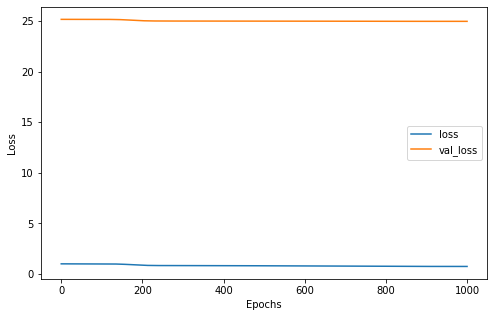

In [34]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.ylabel('Loss')
plt.xlabel('Epochs');